In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import gc
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, association_rules

from scipy.sparse import coo_matrix

#DATA LOADING AND DATA UNDERSTANDING

### Fungsi mengurangi penggunaan memori

In [2]:
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

def data_generator(df, chunksize=10000):
    for i in range(0, df.shape[0], chunksize):
        yield df.iloc[i:i+chunksize]

### Fetch dataset dari Kaggle

In [3]:
# Download latest version
path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/game-recommendations-on-steam


In [4]:
# games = pd.read_csv(path + '/games.csv')
# recommendations = pd.read_csv(path + '/recommendations.csv')
# users = pd.read_csv(path + '/users.csv')
# metadatas = pd.read_json(path + '/games_metadata.json', lines=True)

games = reduce_memory(pd.read_csv(path + '/games.csv'))
recommendations = reduce_memory(pd.read_csv(path + '/recommendations.csv'))
users = reduce_memory(pd.read_csv(path + '/users.csv'))
metadatas = reduce_memory(pd.read_json(path + '/games_metadata.json', lines=True))

print(recommendations.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int32  
 1   helpful         int32  
 2   funny           int32  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float32
 6   user_id         int32  
 7   review_id       int32  
dtypes: bool(1), float32(1), int32(5), object(1)
memory usage: 3.5 GB
None


## Cek dataset

### Cek panjang data

In [5]:
print(games.shape)
print(recommendations.shape)
print(users.shape)
print(metadatas.shape)

(50872, 13)
(41154794, 8)
(14306064, 3)
(50872, 3)


###Cek informasi tiap tabel

In [6]:
print(games.info())
print(recommendations.info())
print(users.info())
print(metadatas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int32  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int32  
 8   user_reviews    50872 non-null  int32  
 9   price_final     50872 non-null  float32
 10  price_original  50872 non-null  float32
 11  discount        50872 non-null  float32
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float32(3), int32(3), object(3)
memory usage: 2.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype

###Cek Missing Values

In [7]:
print("Users Dataset:\n", users.isnull().sum())
print("\nGames Dataset:\n", games.isnull().sum())
print("\nRecommendations Dataset:\n", recommendations.isnull().sum())
print("\nMetadatas Dataset:\n", metadatas.isnull().sum())

Users Dataset:
 user_id     0
products    0
reviews     0
dtype: int64

Games Dataset:
 app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

Recommendations Dataset:
 app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

Metadatas Dataset:
 app_id         0
description    0
tags           0
dtype: int64


###Cek isi dataset

Convert kolom date_release ke format datetime

In [8]:
games['date_release'] = pd.to_datetime(games['date_release'])
recommendations['date'] = pd.to_datetime(recommendations['date'])

Filter dataset recommendations (memakan banyak RAM)

In [9]:
recommendations_final = recommendations[
    (recommendations['hours'] > 2) &
    (recommendations['hours'] < (
        recommendations['hours'].quantile(.75) + 1.5 * (recommendations['hours'].quantile(.75) - recommendations['hours'].quantile(.25))
    ))
].copy()
recommendations_final = reduce_memory(recommendations_final)

Hapus dataset recommendations pra filter

In [10]:
del recommendations
gc.collect()

20

In [11]:
games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


In [12]:
recommendations_final

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4
5,306130,0,0,2021-10-10,True,8.600000,45425,5
...,...,...,...,...,...,...,...,...
41154788,391220,0,0,2021-04-28,True,18.000000,9958247,41154788
41154789,633230,0,0,2021-02-15,True,41.000000,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.000000,1786254,41154790
41154792,696170,0,0,2018-06-11,True,4.000000,1044289,41154792


In [13]:
users

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


In [14]:
metadatas

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...
50867,2296380,,[]
50868,1272080,,[]
50869,1402110,,[]
50870,2272250,Embark on a journey into the darkest nightmare...,"[Early Access, FPS, Action, Retro, First-Perso..."


#EXPLORATORY DATA ANALYSIS (EDA)

##Analisis Games

###Distribusi game berdasarkan rating

<ipython-input-15-0eb26d331a69>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=games, x='rating', palette='crest')


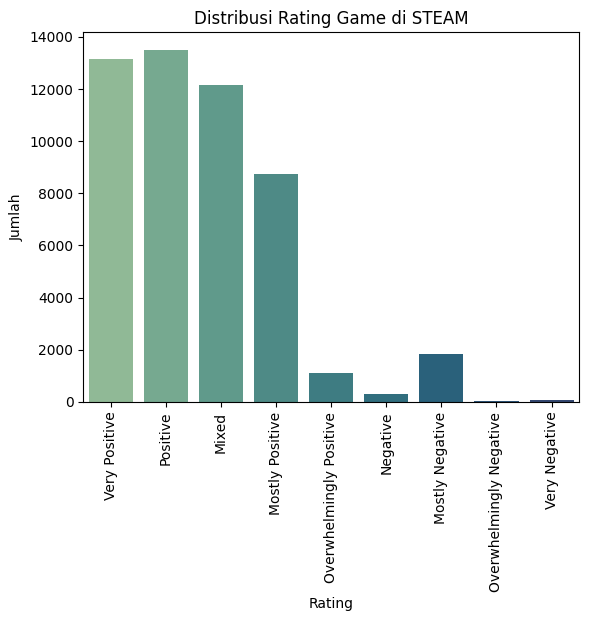

In [15]:
sns.countplot(data=games, x='rating', palette='crest')
plt.title('Distribusi Rating Game di STEAM')
plt.xlabel('Rating')
plt.xticks(rotation=90)
plt.ylabel('Jumlah')
plt.show()

###Distribusi game berdasarkan Tags

In [16]:
from collections import Counter

all_tags = metadatas['tags'].dropna().explode()
tag_counts = Counter(tag for tags in metadatas['tags'].dropna() for tag in tags)

In [17]:
tags_df = pd.DataFrame(tag_counts.items(), columns=['tag', 'count'])
tags_df = tags_df.sort_values('count', ascending=False)

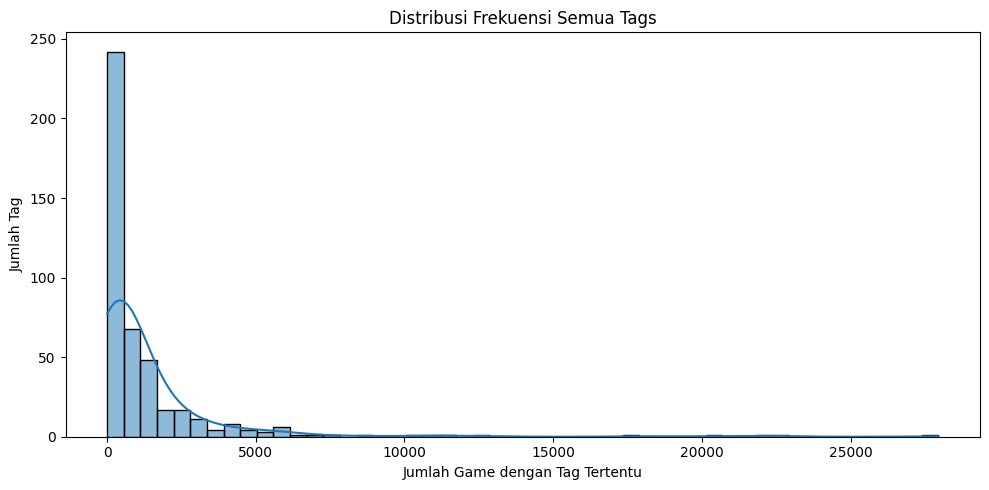

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(tags_df['count'], bins=50, kde=True)
plt.title("Distribusi Frekuensi Semua Tags")
plt.xlabel("Jumlah Game dengan Tag Tertentu")
plt.ylabel("Jumlah Tag")
plt.tight_layout()
plt.show()

In [19]:
from collections import Counter
tag_counter = Counter(tag for tags in metadatas['tags'].dropna() for tag in tags)
top_20_tags = pd.DataFrame(tag_counter.most_common(15), columns=["Tag", "Count"])

<ipython-input-20-2cc00ad57b23>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_tags, x="Tag", y="Count", palette="crest")


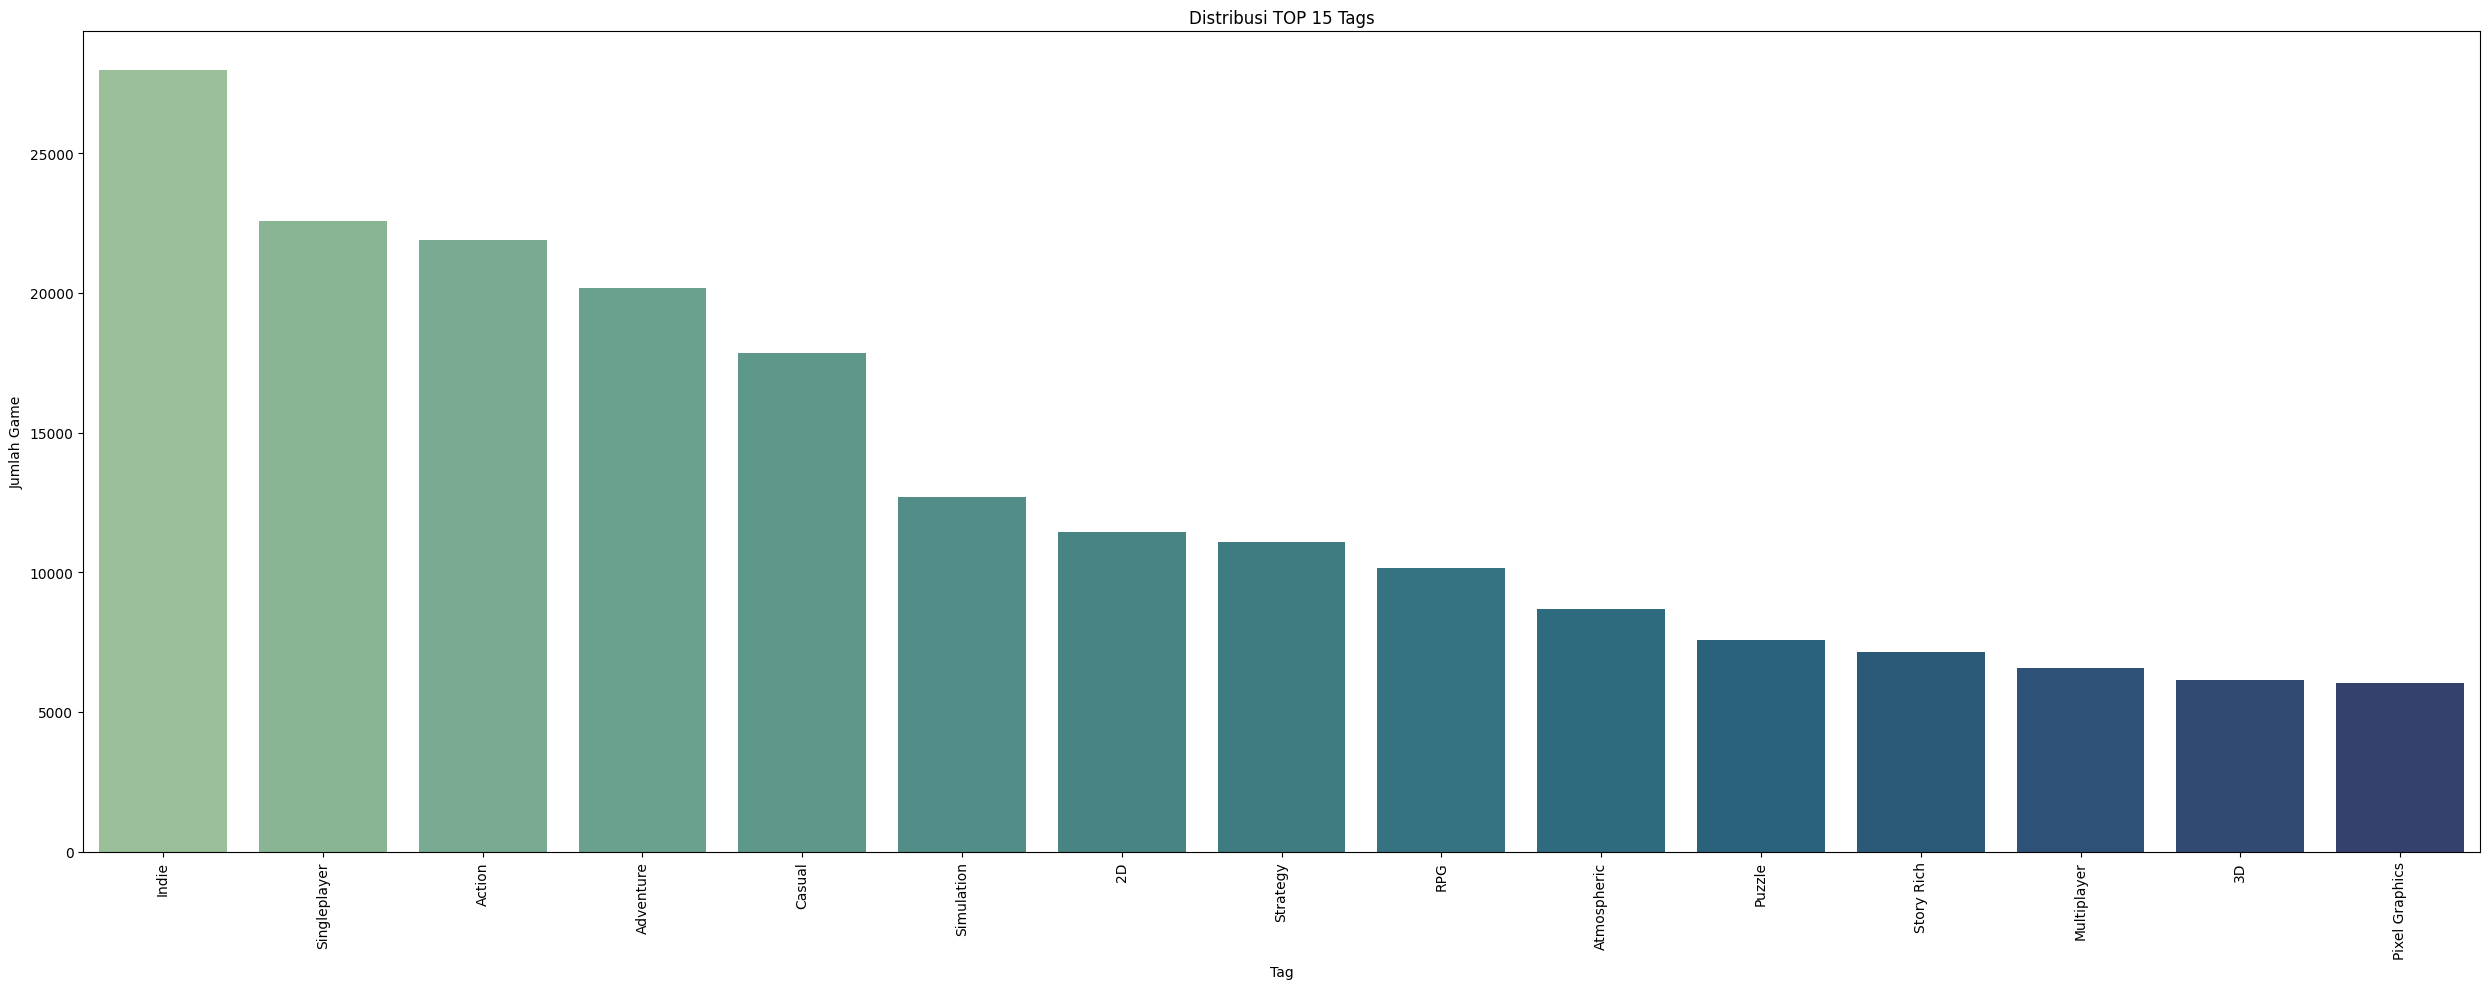

In [20]:
plt.figure(figsize=(25, 10))
sns.barplot(data=top_20_tags, x="Tag", y="Count", palette="crest")
plt.xticks(rotation=90)
plt.title("Distribusi TOP 15 Tags")
plt.xlabel("Tag")
plt.ylabel("Jumlah Game")
plt.tight_layout()
plt.show()

###Distribusi game berdasarkan platform

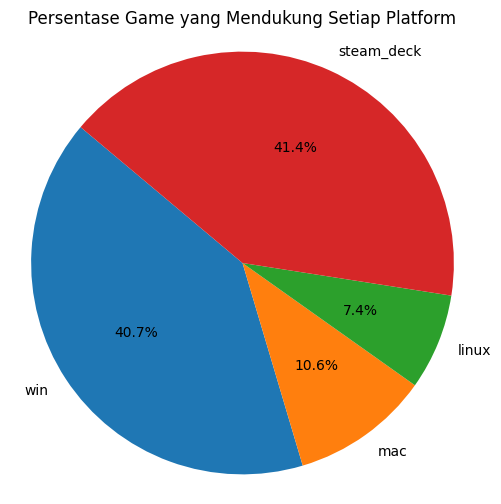

In [21]:
platform_counts = games[['win', 'mac', 'linux', 'steam_deck']].sum()

plt.figure(figsize=(6, 6))
plt.pie(platform_counts, labels=platform_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Persentase Game yang Mendukung Setiap Platform')
plt.axis('equal')
plt.show()

###Distribusi diskon dan harga

Text(0.5, 1.0, 'Distribusi Diskon Game di STEAM')

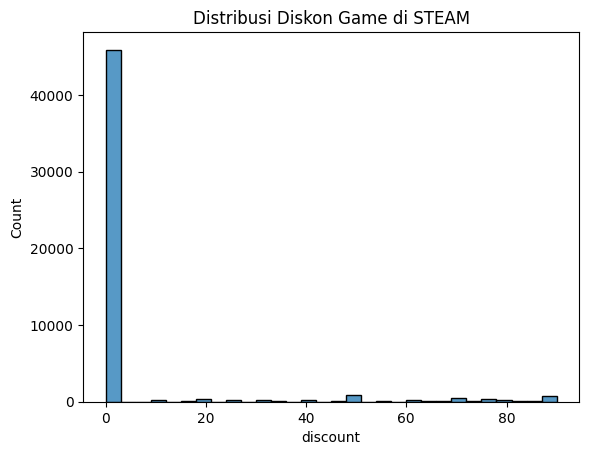

In [22]:
sns.histplot(data=games, x='discount', bins=30)
plt.title('Distribusi Diskon Game di STEAM')

Text(0.5, 1.0, 'Distribusi Harga Akhir Game')

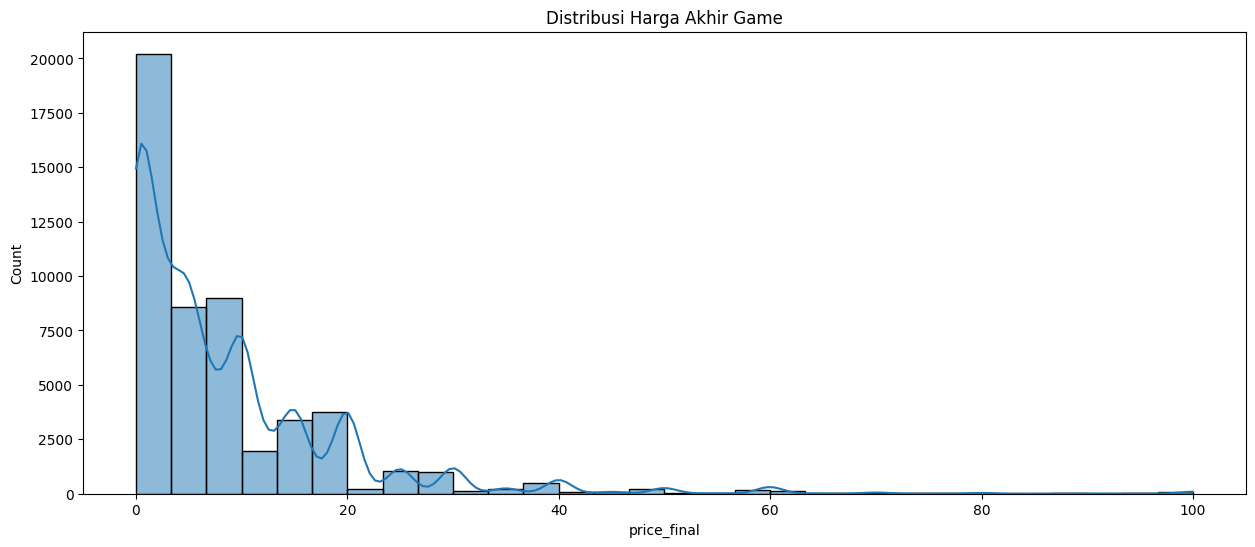

In [23]:
plt.figure(figsize=(15, 6))
sns.histplot(data=games[games['price_final'] < 100], x='price_final', bins=30, kde=True)
plt.title('Distribusi Harga Akhir Game')

###Game populer dengan review terbanyak

<ipython-input-24-8f20967c0b2d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_games, y='title', x='user_reviews', palette='crest')


Text(0.5, 1.0, '10 Game dengan Review Terbanyak')

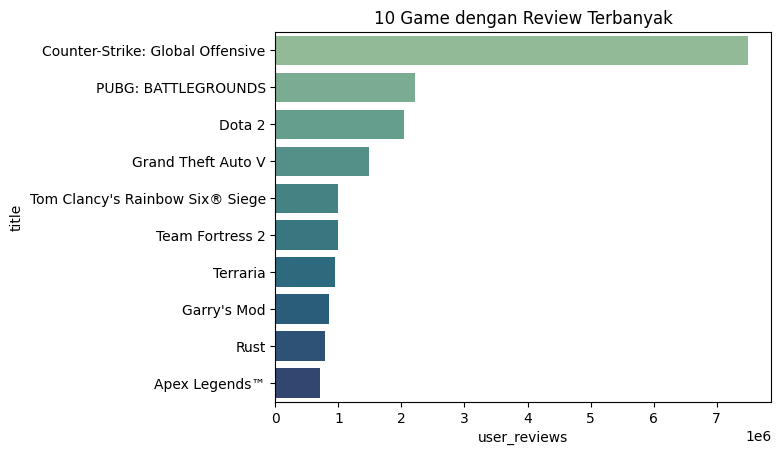

In [24]:
top_games = games.sort_values('user_reviews', ascending=False).head(10)
sns.barplot(data=top_games, y='title', x='user_reviews', palette='crest')
plt.title('10 Game dengan Review Terbanyak')

###Tren rilis game

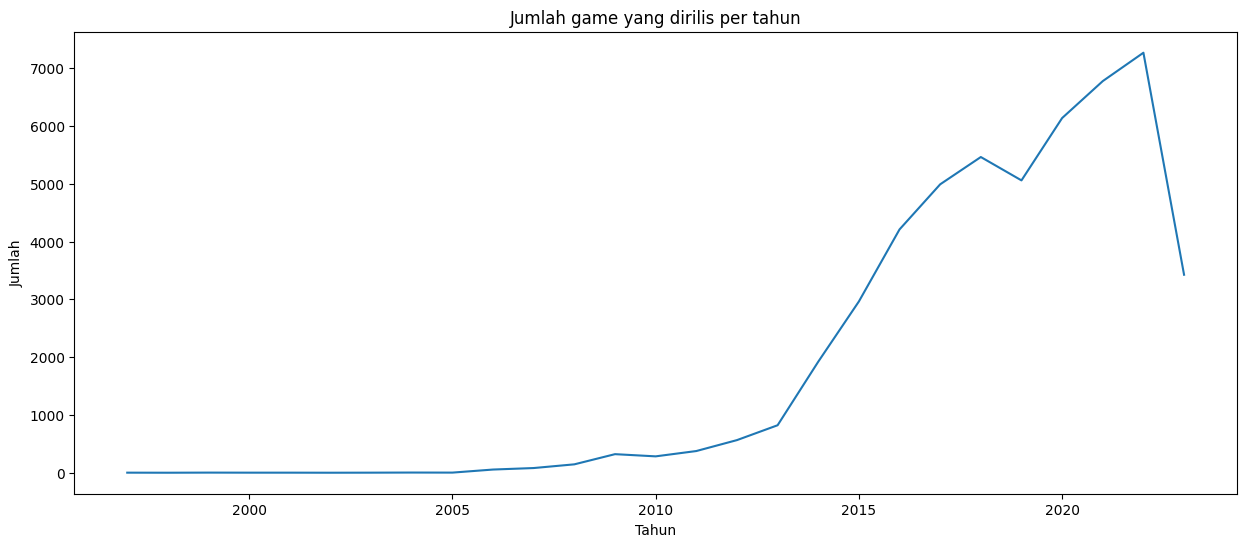

In [25]:
plt.figure(figsize=(15, 6))
games['date_release'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Jumlah game yang dirilis per tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.show()

##Analisis Users

###Distribusi jumlah game yang dimiliki user

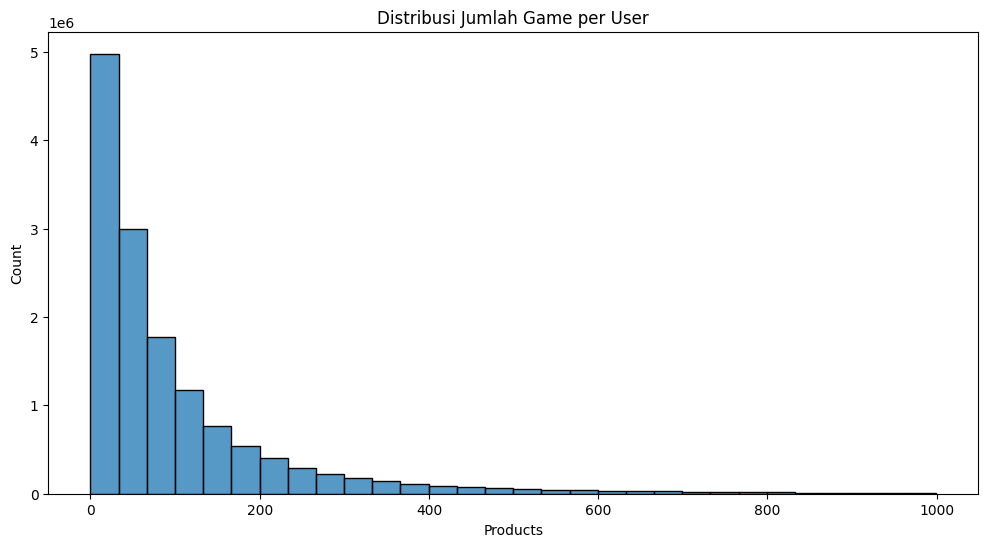

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(data=users[users['products'] < 1000], x='products', bins=30)
plt.title('Distribusi Jumlah Game per User')
plt.xlabel('Products')
plt.show()

###Distribusi jumlah review yg ditulis per User

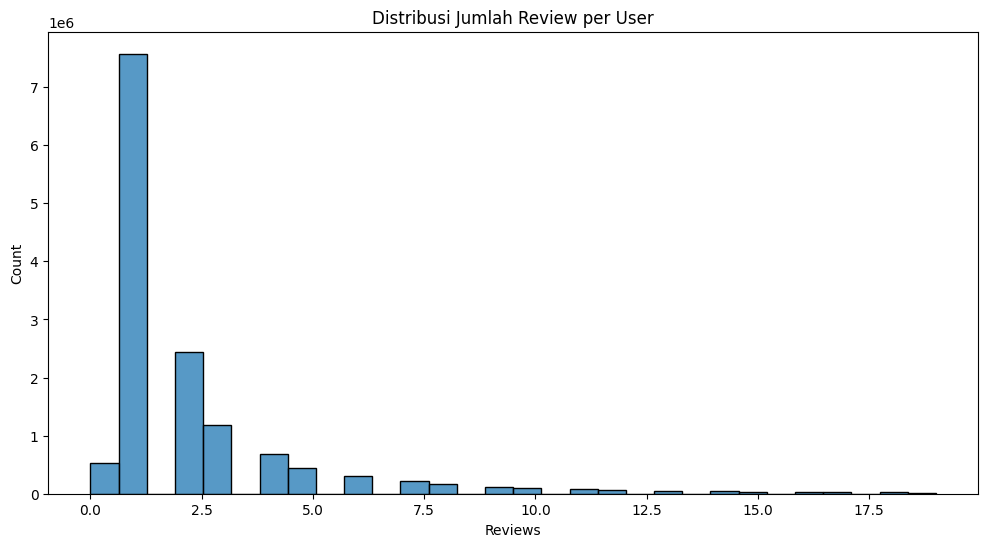

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(data=users[users['reviews'] < 20], x='reviews', bins=30)
plt.title('Distribusi Jumlah Review per User')
plt.xlabel('Reviews')
plt.show()

##Analisis Recommends

###Dsitribusi playtime

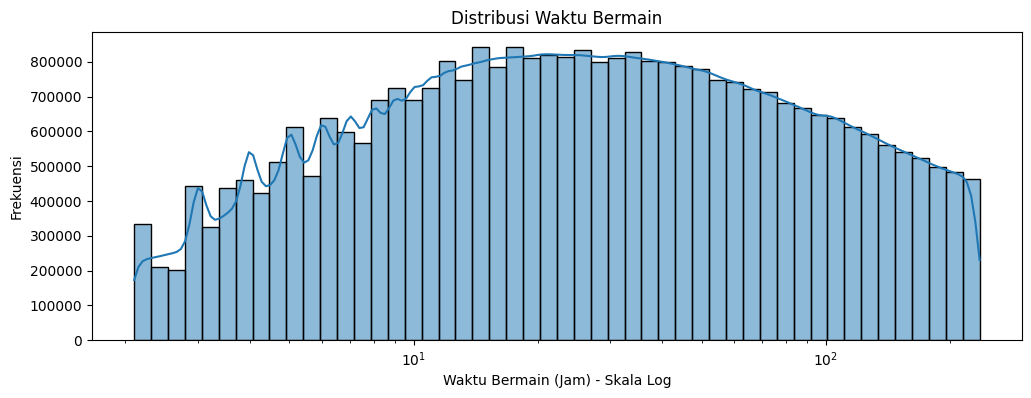

In [28]:
plt.figure(figsize=(12, 4))
sns.histplot(data=recommendations_final, x='hours', bins=50, kde=True, log_scale=True)
plt.title('Distribusi Waktu Bermain')
plt.xlabel('Waktu Bermain (Jam) - Skala Log')
plt.ylabel('Frekuensi')
plt.show()

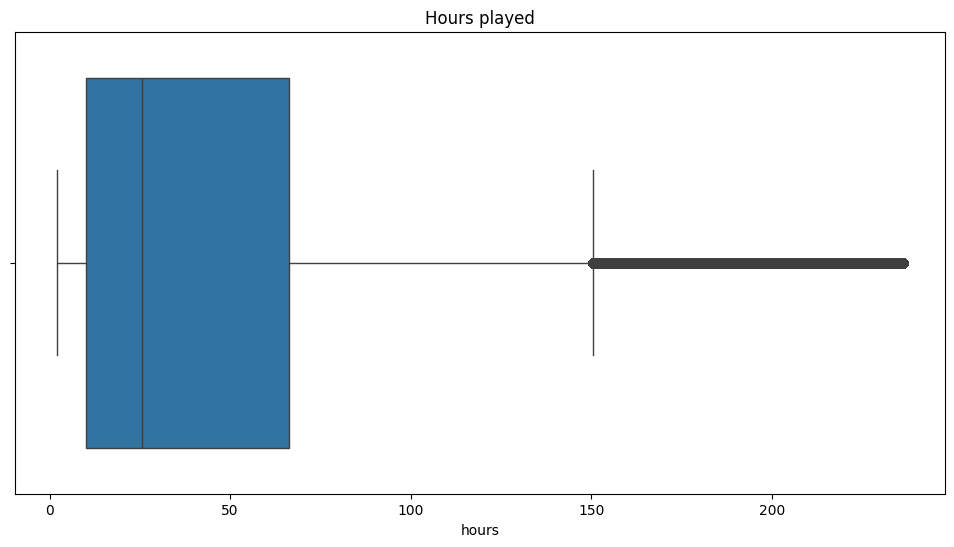

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=recommendations_final, x='hours')
plt.title('Hours played')
plt.show()

#DATA PREPARATION

###Merge dataset games dengan metadata untuk mendapatkan deskripsi serta tags tiap game

In [30]:
game_final = pd.merge(
    games, metadatas, on = 'app_id', how = 'inner'
)
game_final = reduce_memory(game_final)
game_final.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,,[Action]
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [31]:
merged_df = recommendations_final.merge(game_final[['app_id', 'title']], on='app_id', how='inner')

In [32]:
filtered_df = merged_df[merged_df['is_recommended'] == True]

Tidak memakai pivot table untuk mengurangi memory usage

In [33]:
# user_game_matrix = filtered_df.pivot_table(index='user_id', columns='title', values='hours', fill_value=0)

user_to_idx = {user_id: idx for idx, user_id in enumerate(recommendations_final['user_id'].unique())}
game_to_idx = {app_id: idx for idx, app_id in enumerate(recommendations_final['app_id'].unique())}

idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
idx_to_game = {idx: app_id for app_id, idx in game_to_idx.items()}

In [34]:
user_indices = filtered_df['user_id'].map(user_to_idx)
game_indices = filtered_df['title'].map(game_to_idx)
# hours_values = filtered_df['hours'].values

In [35]:
valid_mask = user_indices.notna() & game_indices.notna()

user_indices = user_indices[valid_mask].astype(int).values
game_indices = game_indices[valid_mask].astype(int).values
hours_values = filtered_df['hours'][valid_mask]

#MODELING

##USER BASED COLLABORATIVE FILTERING

In [36]:
num_users_ubf = len(user_to_idx)
num_games_ubf = len(game_to_idx)
user_game_sparse_matrix_ubf = csr_matrix((hours_values, (user_indices, game_indices)), shape=(num_users_ubf, num_games_ubf))

Fit model KNN

In [37]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_game_sparse_matrix_ubf)

NearestNeighbors(algorithm='brute', metric='cosine')

In [38]:
def ubf(user_id, top_n=5):
    if user_id not in user_to_idx:
        print(f"User ID {user_id} not found in the dataset for UBF.")
        return []

    user_idx = user_to_idx[user_id]
    # similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6]

    distances, indices = model_knn.kneighbors(user_game_sparse_matrix_ubf.getrow(user_idx), n_neighbors=top_n + 1)
    similar_users_codes = indices.flatten()[1:]
    similar_users_ids = [idx_to_user[code] for code in similar_users_codes]

    # rekomendasi
    games_played_by_user = set(recommendations_final[recommendations_final['user_id'] == user_id]['app_id'].unique())

    recommendations_score = {}
    for sim_user_id in similar_users_ids:
        sim_user_recs = recommendations_final[recommendations_final['user_id'] == sim_user_id]
        for _, row in sim_user_recs.iterrows():
            app_id = row['app_id']
            hours = row['hours']
            if app_id not in games_played_by_user:
                recommendations_score[app_id] = recommendations_score.get(app_id, 0) + hours
    sorted_recs = sorted(recommendations_score.items(), key=lambda item: item[1], reverse=True)
    recommended_game_titles = []
    for app_id, _ in sorted_recs[:top_n]:
        game_info = game_final[game_final['app_id'] == app_id]
        if not game_info.empty:
            title = game_info['title'].iloc[0]
            recommended_game_titles.append(title)
        else:
            print(f"Warning: app_id {app_id} tidak ditemukan.")
    return recommended_game_titles

##CONTENT BASED

TF-IDF dengan Cosine similarity

In [39]:
game_final['tags_string'] = game_final['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
game_final['combined_features'] = game_final['title'].fillna('') + ' ' + game_final['tags_string']

In [40]:
print(filtered_df.info())
print(game_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28076426 entries, 0 to 31801778
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   app_id          int32         
 1   helpful         int32         
 2   funny           int32         
 3   date            datetime64[ns]
 4   is_recommended  bool          
 5   hours           float32       
 6   user_id         int32         
 7   review_id       int32         
 8   title           object        
dtypes: bool(1), datetime64[ns](1), float32(1), int32(5), object(1)
memory usage: 1.3+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   app_id             50872 non-null  int32         
 1   title              50872 non-null  object        
 2   date_release       50872 non-null  datetime64[ns]
 3   win        

In [41]:
tfidf = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 2), min_df=5)
tfidf_matrix = tfidf.fit_transform(game_final['combined_features'])

title_to_index = pd.Series(game_final.index, index=game_final['title'])

In [42]:
def cbf(game_title, top_n=5):
    if game_title not in title_to_index:
        print(f"Game '{game_title}' tidak ditemukan.")
        return []
    idx = title_to_index[game_title]
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    similar_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]
    return game_final.iloc[similar_indices]['title']

##HYBRID

In [43]:
def hybrid(user_id, top_n=5):
    user_based_titles = ubf(user_id, top_n=20)
    user_based_app_ids = []
    for title in user_based_titles:
        game_info = game_final[game_final['title'] == title]
        if not game_info.empty:
            user_based_app_ids.append(game_info['app_id'].iloc[0])
    user_based_app_ids = list(set(user_based_app_ids))

    games_played_by_target_user = set(recommendations_final[recommendations_final['user_id'] == user_id]['app_id'].unique())

    hybrid_scores = {}
    for app_id in user_based_app_ids:
        game_info_in_final = game_final[game_final['app_id'] == app_id]
        if not game_info_in_final.empty:
            game_idx_in_final = game_info_in_final.index[0]
            cosine_sims = linear_kernel(tfidf_matrix[game_idx_in_final], tfidf_matrix).flatten()
            for i, score in enumerate(cosine_sims):
                current_game_app_id = game_final.iloc[i]['app_id']
                if current_game_app_id not in games_played_by_target_user:
                    hybrid_scores[current_game_app_id] = hybrid_scores.get(current_game_app_id, 0) + score
    sorted_hybrid = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)

    recommended_titles = []
    for app_id, _ in sorted_hybrid:
        game_info = game_final[game_final['app_id'] == app_id]
        if not game_info.empty:
            title = game_info['title'].iloc[0]
            recommended_titles.append(title)
        if len(recommended_titles) == top_n:
            break

    return recommended_titles

#TES

In [44]:
recommendations_final

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4
5,306130,0,0,2021-10-10,True,8.600000,45425,5
...,...,...,...,...,...,...,...,...
41154788,391220,0,0,2021-04-28,True,18.000000,9958247,41154788
41154789,633230,0,0,2021-02-15,True,41.000000,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.000000,1786254,41154790
41154792,696170,0,0,2018-06-11,True,4.000000,1044289,41154792


In [45]:
print("📘 User-Based:", ubf(51580))
print("📗 Content-Based:", cbf("Dota 2"))
print("📙 Hybrid:", hybrid(51580))

📘 User-Based: ['Vampire: The Masquerade - Bloodhunt', 'Warface', 'STAR WARS™ Battlefront™ II', 'Ori and the Will of the Wisps']
📗 Content-Based: 17916               The Dota 2 Official Soundtrack
45147                        The Dota 2 Remixes EP
23964                       Dota 2 Player Profiles
12528                              Dota Underlords
16962    Pinball FX3 - Williams™ Pinball: Volume 6
Name: title, dtype: object
📙 Hybrid: ['Rise of the Tomb Raider™', 'Far Cry® 4', 'Sniper Elite 3', 'Nioh 2 – The Complete Edition', 'Ori and the Will of the Wisps']


#VISUALISASI AKHIR

Chart skor kemiripan game

<ipython-input-49-ac3651b20e09>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=similar_titles, y=similar_scores, palette='crest')


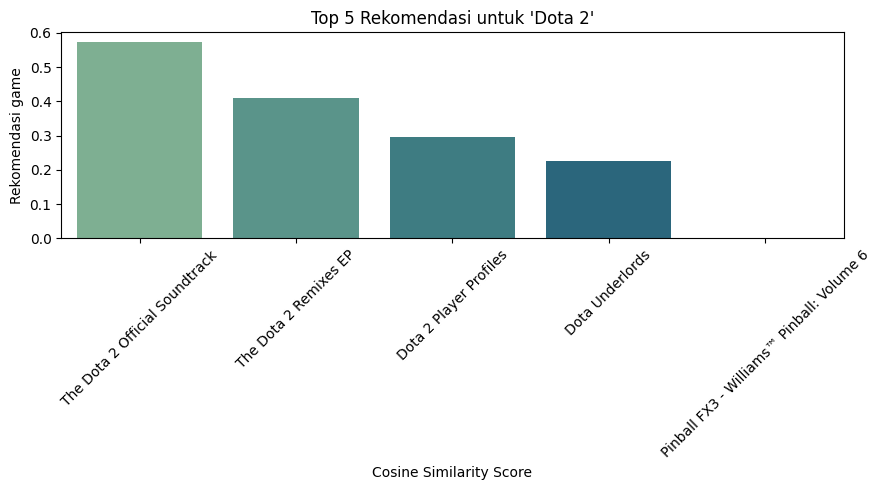

In [49]:
def plot_recommendations(title, top_n=5):
    idx = title_to_index[title]
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    similar_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]
    similar_scores = cosine_similarities[similar_indices]
    similar_titles = game_final.iloc[similar_indices]['title'].values
    plt.figure(figsize=(9, 5))
    sns.barplot(x=similar_titles, y=similar_scores, palette='crest')
    plt.xlabel('Cosine Similarity Score')
    plt.ylabel('Rekomendasi game')
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Rekomendasi untuk '{title}'")
    plt.tight_layout()
    plt.show()

plot_recommendations("Dota 2", top_n=5)

Distribusi skor kemiripan

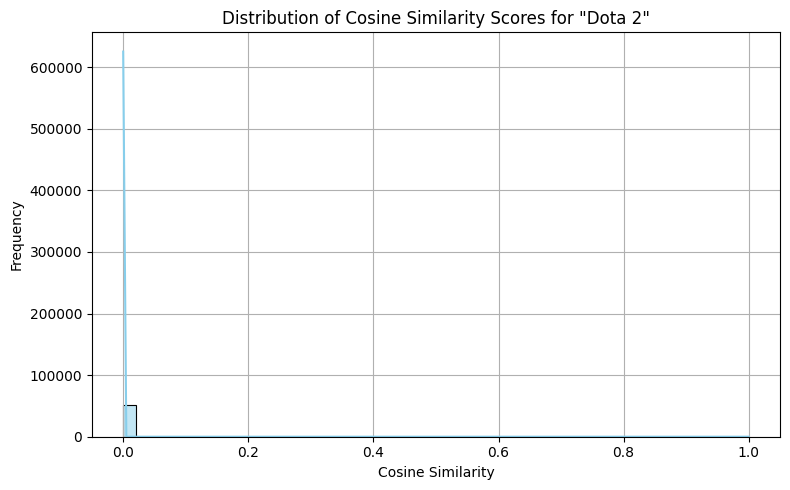

In [50]:
def plot_similarity_distribution(title):
    idx = title_to_index[title]
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()

    plt.figure(figsize=(8, 5))
    sns.histplot(cosine_similarities, bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of Cosine Similarity Scores for "{title}"')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_similarity_distribution("Dota 2")

Hasil rekomendasi

In [51]:
def get_recommendation_df(title, top_n=5):
    idx = title_to_index[title]
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    similar_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]

    result_df = game_final.iloc[similar_indices][['title', 'tags_string']].copy()
    result_df['similarity_score'] = cosine_similarities[similar_indices]
    return result_df

get_recommendation_df("Dota 2", top_n=5)

,title,tags_string,similarity_score
17916,The Dota 2 Official Soundtrack,Soundtrack,0.573195
45147,The Dota 2 Remixes EP,Free to Play Strategy Action Soundtrack Electr...,0.409921
23964,Dota 2 Player Profiles,Gaming Free to Play Documentary Episodic MOBA ...,0.297191
12528,Dota Underlords,Free to Play Strategy Casual Auto Battler Mult...,0.225633
16962,Pinball FX3 - Williams™ Pinball: Volume 6,Simulation,0.000000
